In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
from utils_timeline_viz import *
from utils_read_parsing import *
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import ranksums
import seaborn as sns
import statsmodels.api as sm
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
from statsmodels.discrete.discrete_model import Logit
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 7, 4
pd.set_option('precision',3)
np.set_printoptions(precision=3,suppress=True)

d:\applications\anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Preparing the data
We wish to have a table that looks like:

In [3]:
t = [['student','variable','pre','post','index','sim','CVS table','CVS graph']]
t.append(['s1','v1','1.0','2.333','1','L','Yes','No'])
t.append(['s1','v2','...','...','1','L','Yes','Yes'])
t.append(['s1','v3','...','...','2','C','No','No'])
t.append(['s1','v4','...','...','2','C','Yes','No'])
print tabulate(t)

-------  --------  ---  -----  -----  ---  ---------  ---------
student  variable  pre  post   index  sim  CVS table  CVS graph
s1       v1        1.0  2.333  1      L    Yes        No
s1       v2        ...  ...    1      L    Yes        Yes
s1       v3        ...  ...    2      C    No         No
s1       v4        ...  ...    2      C    Yes        No
-------  --------  ---  -----  -----  ---  ---------  ---------


## Grabing the CVS data...

In [4]:
table_cvs_df = pd.read_csv('table_cvs_results.txt', sep='\t')
graph_cvs_df = pd.read_csv('graph_cvs_results.txt', sep='\t')

In [5]:
metadf = get_student_metadata()
order = dict(zip(metadf.index,metadf['activity order']))
graph_cvs_df['activity order'] = graph_cvs_df.studentid.apply(lambda sid: order[sid])
table_cvs_df['activity order'] = table_cvs_df.studentid.apply(lambda sid: order[sid])

In [6]:
table_cvs_df.head()

,studentid,Battery voltage,Area,Separation,Wavelength,Width,Concentration,activity order
0,11612162,0,0,0,3,2,3,CL
1,13660166,0,0,0,0,0,14,LC
2,41947147,2,0,0,14,6,7,CL
3,64006159,0,0,0,5,0,6,LC
4,15749160,0,2,3,0,4,10,CL


In [7]:
variables = ["Area","Separation","Width","Concentration","Wavelength","Battery voltage"]

def binarize(threshold,number):
    if number>= threshold : return 1
    else: return 0
    
# Given that we want to compare the stringency of CVS, we created different definitions with 2,3,4 points needed

graph_cvs_2_df = graph_cvs_df.copy()
graph_cvs_3_df = graph_cvs_df.copy()
graph_cvs_4_df = graph_cvs_df.copy()
graph_cvs_5_df = graph_cvs_df.copy()
for v in variables:
    graph_cvs_2_df[v] = graph_cvs_df.apply(lambda row: binarize(2,row[v]), axis=1)
    graph_cvs_3_df[v] = graph_cvs_df.apply(lambda row: binarize(3,row[v]), axis=1)
    graph_cvs_4_df[v] = graph_cvs_df.apply(lambda row: binarize(4,row[v]), axis=1)
    graph_cvs_5_df[v] = graph_cvs_df.apply(lambda row: binarize(5,row[v]), axis=1)

table_cvs_2_df = table_cvs_df.copy()
table_cvs_3_df = table_cvs_df.copy()
table_cvs_4_df = table_cvs_df.copy()
table_cvs_5_df = table_cvs_df.copy()
for v in variables:
    table_cvs_2_df[v] = table_cvs_df.apply(lambda row: binarize(2,row[v]), axis=1)
    table_cvs_3_df[v] = table_cvs_df.apply(lambda row: binarize(3,row[v]), axis=1)
    table_cvs_4_df[v] = table_cvs_df.apply(lambda row: binarize(4,row[v]), axis=1)
    table_cvs_5_df[v] = table_cvs_df.apply(lambda row: binarize(5,row[v]), axis=1)
table_cvs_5_df.head()

,studentid,Battery voltage,Area,Separation,Wavelength,Width,Concentration,activity order
0,11612162,0,0,0,0,0,0,CL
1,13660166,0,0,0,0,0,1,LC
2,41947147,0,0,0,1,1,1,CL
3,64006159,0,0,0,1,0,1,LC
4,15749160,0,0,0,0,0,1,CL


In [8]:
table_intervals_df = pd.read_csv('table_intervals_results.txt', sep='\t')

## Grabbing the worksheet data

In [9]:
%reload_ext utils_read_parsing
#grab worksheet data
worksheets = get_worksheet_metadata('beers')
pre = get_pre_worksheet(sim='beers')
main = get_main_worksheet(sim='beers')

ids = get_students_to_analyze_log_worksheets('beers')
pre= pre[pre['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]
main= main[main['Student ID'].isin(worksheets[(worksheets['Type']=='m')&worksheets['Student ID'].isin(ids)]['other id'].values)]

#ids in pre/post match "other id" in worksheet metdata so we need to assign the correct id in logs for each entry in pre/post
pre['sid'] = pre['Student ID'].apply(lambda row: worksheets.loc[worksheets[(worksheets['other id']==row)].index[0],'Student ID'])
main['sid'] = main['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])

# print len(ids),len(pre),len(main)

In [10]:
## make desired table for beers
melted_pre = pd.melt(pre, id_vars=['sid'], value_vars=['Concentration','Width'], var_name='variable',value_name='pre')
melted_main = pd.melt(main, id_vars=['sid'], value_vars=['Concentration','Width'], var_name='variable',value_name='main')

L_scores = melted_pre.merge(melted_main, on=['sid','variable'], how='outer')
L_scores['sim'] = 'L'

L_scores['CVS_table_2'] = L_scores.apply(lambda row: table_cvs_2_df.loc[table_cvs_2_df[table_cvs_2_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
L_scores['CVS_graph_2'] = L_scores.apply(lambda row: graph_cvs_2_df.loc[graph_cvs_2_df[graph_cvs_2_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

L_scores['CVS_table_3'] = L_scores.apply(lambda row: table_cvs_3_df.loc[table_cvs_3_df[table_cvs_3_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
L_scores['CVS_graph_3'] = L_scores.apply(lambda row: graph_cvs_3_df.loc[graph_cvs_3_df[graph_cvs_3_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

L_scores['CVS_table_4'] = L_scores.apply(lambda row: table_cvs_4_df.loc[table_cvs_4_df[table_cvs_4_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
L_scores['CVS_graph_4'] = L_scores.apply(lambda row: graph_cvs_4_df.loc[graph_cvs_4_df[graph_cvs_4_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

L_scores['CVS_table_5'] = L_scores.apply(lambda row: table_cvs_5_df.loc[table_cvs_5_df[table_cvs_5_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
L_scores['CVS_graph_5'] = L_scores.apply(lambda row: graph_cvs_5_df.loc[graph_cvs_5_df[graph_cvs_5_df['studentid']==row['sid']].index[0],row['variable']],axis=1)


L_scores['number_points_table'] = L_scores.apply(lambda row: table_cvs_df.loc[table_cvs_df[table_cvs_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
L_scores['number_points_graph'] = L_scores.apply(lambda row: graph_cvs_df.loc[graph_cvs_df[graph_cvs_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

L_scores['sim_index'] = L_scores.apply(lambda row: table_cvs_2_df.loc[table_cvs_2_df[table_cvs_2_df['studentid']==row['sid']].index[0],'activity order'].index(row['sim'])+1,axis=1)

In [11]:
L_scores[L_scores['variable']=='Width'].describe()

,sid,pre,main,CVS_table_2,CVS_graph_2,CVS_table_3,CVS_graph_3,CVS_table_4,CVS_graph_4,CVS_table_5,CVS_graph_5,number_points_table,number_points_graph,sim_index
count,1.480e+02,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000
mean,2.204e+07,1.027,2.318,0.736,0.480,0.595,0.446,0.520,0.426,0.412,0.318,4.351,3.236,1.486
std,1.808e+07,0.833,0.756,0.442,0.501,0.493,0.499,0.501,0.496,0.494,0.467,4.322,4.366,0.502
min,1.013e+07,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,1.354e+07,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
50%,1.670e+07,1.000,2.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,4.000,0.000,1.000
75%,1.936e+07,2.000,3.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,7.000,6.000,2.000
max,9.045e+07,3.000,3.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,23.000,23.000,2.000


In [12]:
%reload_ext utils_read_parsing
#grab worksheet data
worksheets = get_worksheet_metadata('caps')
pre = get_pre_worksheet(sim='caps')
main = get_main_worksheet(sim='caps')

ids = get_students_to_analyze_log_worksheets('caps')
pre= pre[pre['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]
main= main[main['Student ID'].isin(worksheets[(worksheets['Type']=='m')&worksheets['Student ID'].isin(ids)]['other id'].values)]

#ids in pre/post match "other id" in worksheet metdata so we need to assign the correct id in logs for each entry in pre/post
pre['sid'] = pre['Student ID'].apply(lambda row: worksheets.loc[worksheets[(worksheets['other id']==row)].index[0],'Student ID'])
main['sid'] = main['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])

# print len(ids),len(pre),len(main)

In [13]:
## make desired table for caps
melted_pre = pd.melt(pre, id_vars=['sid'], value_vars=['Area','Separation'], var_name='variable',value_name='pre')
melted_main = pd.melt(main, id_vars=['sid'], value_vars=['Area','Separation'], var_name='variable',value_name='main')

C_scores = melted_pre.merge(melted_main, on=['sid','variable'], how='outer')
C_scores['sim'] = 'C'
C_scores['CVS_table_2'] = C_scores.apply(lambda row: table_cvs_2_df.loc[table_cvs_2_df[table_cvs_2_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
C_scores['CVS_graph_2'] = C_scores.apply(lambda row: graph_cvs_2_df.loc[graph_cvs_2_df[graph_cvs_2_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

C_scores['CVS_table_3'] = C_scores.apply(lambda row: table_cvs_3_df.loc[table_cvs_3_df[table_cvs_3_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
C_scores['CVS_graph_3'] = C_scores.apply(lambda row: graph_cvs_3_df.loc[graph_cvs_3_df[graph_cvs_3_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

C_scores['CVS_table_4'] = C_scores.apply(lambda row: table_cvs_4_df.loc[table_cvs_4_df[table_cvs_4_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
C_scores['CVS_graph_4'] = C_scores.apply(lambda row: graph_cvs_4_df.loc[graph_cvs_4_df[graph_cvs_4_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

C_scores['CVS_table_5'] = C_scores.apply(lambda row: table_cvs_5_df.loc[table_cvs_5_df[table_cvs_5_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
C_scores['CVS_graph_5'] = C_scores.apply(lambda row: graph_cvs_5_df.loc[graph_cvs_5_df[graph_cvs_5_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

C_scores['number_points_table'] = C_scores.apply(lambda row: table_cvs_df.loc[table_cvs_df[table_cvs_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
C_scores['number_points_graph'] = C_scores.apply(lambda row: graph_cvs_df.loc[graph_cvs_df[graph_cvs_df['studentid']==row['sid']].index[0],row['variable']],axis=1)

C_scores['sim_index'] = C_scores.apply(lambda row: table_cvs_2_df.loc[table_cvs_2_df[table_cvs_2_df['studentid']==row['sid']].index[0],'activity order'].index(row['sim'])+1,axis=1)

## Putting it all together

In [14]:
data = pd.concat([L_scores,C_scores])
# data['intervals_in_table'] = data.apply(lambda row: table_intervals_df.loc[table_intervals_df[table_intervals_df['studentid']==row['sid']].index[0],row['variable']],axis=1)
# data['CVS_table_only'] = data.apply(lambda row: row['CVS_table']*(1-row['CVS_graph']), axis = 1)
data = data.reset_index(drop=True)

## Adding pre-survey data

In [15]:
pre_survey_df = pd.read_csv('pre_survey_results.txt', sep='\t')
pre_survey_df.head()

,Unnamed: 0,sid,level_experience_sims,similar_L,similar_C,experience_undergrad_lab_physics
0,5,77047160,2,0,0,1
1,6,23836160,0,0,0,1
2,7,64006159,1,0,0,1
3,8,24566161,3,0,1,1
4,9,46792161,2,1,0,1


In [16]:
data['level_experience_sims'] = data.apply(lambda row: pre_survey_df.loc[pre_survey_df[pre_survey_df['sid']==row['sid']].index[0],'level_experience_sims'], axis=1)
data['experience_undergrad_lab_physics'] = data.apply(lambda row: pre_survey_df.loc[pre_survey_df[pre_survey_df['sid']==row['sid']].index[0],'experience_undergrad_lab_physics'], axis=1)
data['used_similar_sim_L'] = data[data['sim']=='L'].apply(lambda row: pre_survey_df.loc[pre_survey_df[pre_survey_df['sid']==row['sid']].index[0],'similar_L'],axis=1)
data['used_similar_sim_L'].fillna(0, inplace=True)
data['used_similar_sim_C'] = data[data['sim']=='C'].apply(lambda row: pre_survey_df.loc[pre_survey_df[pre_survey_df['sid']==row['sid']].index[0],'similar_C'],axis=1)
data['used_similar_sim_C'].fillna(0, inplace=True)
data['used_similar_sim'] = data['used_similar_sim_L'] + data['used_similar_sim_C']
data.sort_values('sid').head(12)

,sid,variable,pre,main,sim,CVS_table_2,CVS_graph_2,CVS_table_3,CVS_graph_3,CVS_table_4,...,CVS_table_5,CVS_graph_5,number_points_table,number_points_graph,sim_index,level_experience_sims,experience_undergrad_lab_physics,used_similar_sim_L,used_similar_sim_C,used_similar_sim
0,10127163,Concentration,1.0,3.0,L,1,1,1,1,1,...,1,1,7,6,1,1,1,0.0,0.0,0.0
148,10127163,Width,1.0,3.0,L,1,1,1,1,1,...,1,1,7,7,1,1,1,0.0,0.0,0.0
296,10127163,Area,3.0,3.0,C,1,1,1,1,1,...,1,1,8,8,2,1,1,0.0,0.0,0.0
444,10127163,Separation,3.0,3.0,C,1,1,1,1,1,...,1,1,5,5,2,1,1,0.0,0.0,0.0
538,10192168,Separation,1.0,2.0,C,1,1,1,1,1,...,0,0,4,4,1,1,0,0.0,0.0,0.0
96,10192168,Concentration,1.0,3.0,L,1,1,1,1,1,...,1,1,6,6,2,1,0,0.0,0.0,0.0
390,10192168,Area,1.0,2.0,C,1,0,0,0,0,...,0,0,2,0,1,1,0,0.0,0.0,0.0
244,10192168,Width,1.0,0.0,L,1,0,1,0,1,...,1,0,9,0,2,1,0,0.0,0.0,0.0
1,10232160,Concentration,1.0,1.0,L,1,1,1,1,1,...,0,0,4,4,1,1,1,1.0,0.0,1.0
149,10232160,Width,1.0,1.0,L,0,0,0,0,0,...,0,0,0,0,1,1,1,1.0,0.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000EDFC550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000102E35F8>]], dtype=object)

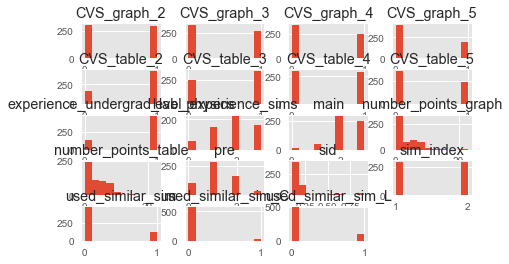

In [17]:
data.hist()

## Stats tools and multicollinearity check

In [18]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def clean_summary(model):
    lines = model.summary().as_text().split('\n')
    lines = [l for l in lines if 'C(sid)' not in l]
    return '\n'.join(lines)

In [19]:
# from scipy import stats
# print "Correlation coeff for table and graph CVS:", stats.spearmanr(data['CVS_table'],data['CVS_graph'])

In [20]:
# #Let's measure the variance inflation factor of including both CVS table and graph in the same models:
# formula = 'CVS_table ~ CVS_graph + pre + C(variable) + C(sim_index) + C(sim) '
# print 'model: ', formula,'\n'
# from patsy import dmatrices
# Y, X = dmatrices(formula, data, return_type = 'dataframe')
# # print X.columns
# logit = Logit(Y, X)
# model = logit.fit()
# print model.summary()
# # print model.params

In [21]:
# R2 = 0.4225
# VIF = 1.0/(1-R2)
# VIF

## A VIF of 1.73 tells us that the variance (the square of the standard error) of a particular coefficient is 73% larger than it would be if that predictor was completely uncorrelated with all the other predictors. According to [this website](https://statisticalhorizons.com/multicollinearity), a VIF of 2.6 or higher is worrisome.

# Results to present in methods
## Student population

In [22]:
N = len(set(data['sid']))
print "The study includes {0} students".format(N)

The study includes 148 students


In [80]:
posts = get_all_posts_surveys()
genders = ['gender','[gender] To which gender do you most identify? [Man]','[gender] To which gender do you most identify? [Gender non conforming/non-binary]','[gender] To which gender do you most identify? [Trans*]','[gender] To which gender do you most identify? [Rather specify:]','[gender] To which gender do you most identify? [Rather specify:] [text]','[gender] To which gender do you most identify? [Prefer not to answer]']
for g in genders:
    print g
    print len(set(posts[posts[g]==1]['sid'])), round(len(set(posts[posts[g]==1]['sid']))/float(N)*100,1)

gender
96 64.9
[gender] To which gender do you most identify? [Man]
50 33.8
[gender] To which gender do you most identify? [Gender non conforming/non-binary]
1 0.7
[gender] To which gender do you most identify? [Trans*]
0 0.0
[gender] To which gender do you most identify? [Rather specify:]
0 0.0
[gender] To which gender do you most identify? [Rather specify:] [text]
0 0.0
[gender] To which gender do you most identify? [Prefer not to answer]
1 0.7


## Student prior experience

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010DBA128>]], dtype=object)

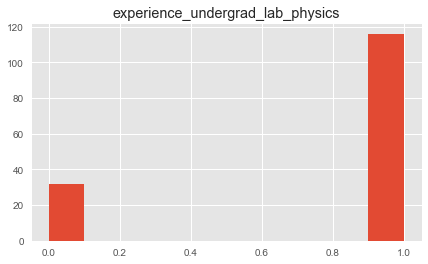

In [26]:
# print 'experience in virtual labs in general'
pd.pivot_table(data, values=['experience_undergrad_lab_physics'], index=['sid'],aggfunc=np.mean)[['experience_undergrad_lab_physics']].hist()

where:
 0 -> None
 1 -> 1-2 (roughly)
 2 -> 3-5 (roughly)
 3 -> 6+ (roughly)


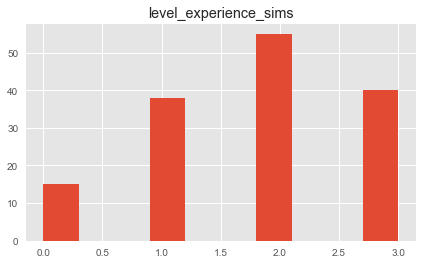

In [27]:
pd.pivot_table(data, values=['level_experience_sims'], index=['sid'],aggfunc=np.mean)[['level_experience_sims']].hist()
print '''where:
 0 -> None
 1 -> 1-2 (roughly)
 2 -> 3-5 (roughly)
 3 -> 6+ (roughly)'''

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000111F0E80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001124E6A0>]], dtype=object)

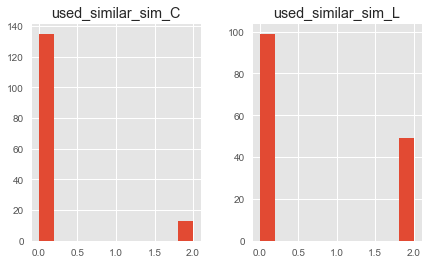

In [28]:
# print  'experience in virtual labs teaching light absorbance or capacitors before'
pd.pivot_table(data, values=['used_similar_sim_C','used_similar_sim_L'], index=['sid'],aggfunc=sum)[['used_similar_sim_C','used_similar_sim_L']].hist()

# Learning through inquiry
## Overall

Let's look at pre to post to see if students learn.

Right now we have 4 entries per student and add "variable" to the model. But then pre matters (p=0.04)
But we could have main = mean(var1 and var 2 scores). In which case pre doesn't matter (p=0.056)
Either way with tiny effect size.

In [29]:
scores = pd.pivot_table(data, values=['pre','main'], index=['sim','sid'],aggfunc=np.mean)
scores.reset_index(level=0, inplace=True)
scores['sid']=scores.index
scores.index = scores['sim']
scores.head()

,sim,main,pre,sid
sim,,,,
C,C,3.0,3.0,10127163
C,C,2.0,1.0,10192168
C,C,3.0,1.0,10232160
C,C,3.0,1.0,10375163
C,C,2.5,2.0,10420167


In [30]:
t = [['sim','pre','post','Z','p','effect size']]
for sim in ['L','C']:
    pm = round(np.mean(scores.loc[sim]['pre']),2)
    ps = round(np.std(scores.loc[sim]['pre']),2)
    mm = round(np.mean(scores.loc[sim]['main']),2)
    ms = round(np.std(scores.loc[sim]['main']),2)
    Z,p = ranksums(scores.loc[sim]['pre'],scores.loc[sim]['main'])
    eta = round(-Z/np.sqrt(N),2)
    t.append([sim,str(pm)+'+/-'+str(ps),str(mm)+'+/-'+str(ms),Z,p,eta])

print tabulate(t)

---  -----------  -----------  --------------  -----------------  -----------
sim  pre          post         Z               p                  effect size
L    1.17+/-0.69  2.35+/-0.63  -11.2795122375  1.65661938815e-29  0.93
C    1.28+/-0.67  2.24+/-0.63  -10.5732694484  3.9642841333e-26   0.87
---  -----------  -----------  --------------  -----------------  -----------


We use Wilcoxon signed rank test since our population ares paired and dependant but ordinal values. Overall, student learn in both sims.

For calculation and interpretation of effect size, read Pages 224 (bottom part) and 225 from Pallant, J. (2007). SPSS Survival Manual quoted [here](https://stats.stackexchange.com/questions/133077/effect-size-to-wilcoxon-signed-rank-test)


# Does using strategy help student learn?

## Using different levels of CVS and learning
We add a "CVS_levels" column to our data (graph=2, table=1, none=0)

In [31]:
data['CVS_levels_2']=0
data['CVS_levels_3']=0
data['CVS_levels_4']=0
data['CVS_levels_5']=0
# data['CVS_table_only'] = data.apply(lambda row: row['CVS_table']*(1-row['CVS_graph']), axis = 1)
data['CVS_levels_2']=data['CVS_table_2']+data['CVS_graph_2']
data['CVS_levels_3']=data['CVS_table_3']+data['CVS_graph_3']
data['CVS_levels_4']=data['CVS_table_4']+data['CVS_graph_4']
data['CVS_levels_5']=data['CVS_table_5']+data['CVS_graph_5']
# print data[(data['CVS_table']==0)&(data['CVS_graph']==1)].shape
data.head()

,sid,variable,pre,main,sim,CVS_table_2,CVS_graph_2,CVS_table_3,CVS_graph_3,CVS_table_4,...,sim_index,level_experience_sims,experience_undergrad_lab_physics,used_similar_sim_L,used_similar_sim_C,used_similar_sim,CVS_levels_2,CVS_levels_3,CVS_levels_4,CVS_levels_5
0,10127163,Concentration,1.0,3.0,L,1,1,1,1,1,...,1,1,1,0.0,0.0,0.0,2,2,2,2
1,10232160,Concentration,1.0,1.0,L,1,1,1,1,1,...,1,1,1,1.0,0.0,1.0,2,2,2,0
2,10537160,Concentration,1.0,2.0,L,1,0,1,0,0,...,2,1,0,1.0,0.0,1.0,1,1,0,0
3,10375163,Concentration,0.0,2.0,L,1,0,1,0,1,...,2,2,1,0.0,0.0,0.0,1,1,1,1
4,10420167,Concentration,1.0,3.0,L,1,1,1,1,1,...,2,3,1,0.0,0.0,0.0,2,2,2,2


In [32]:
# export_data = data[["sid","variable","pre","main","sim","CVS_table","CVS_graph","CVS_table_only","CVS_levels","sim_index"]]
# export_data.to_csv('dataframe for linear reg on learning.csv')

We have 7 control variables:
* sim_index
* sim
* variable
* pre
* level_experience_sims
* experience_undergrad_lab_physics
* used_similar_sim

We look at all interactions with CVS levels given our RQ are related to CVS usage:
* variable*CVS_levels
* pre*CVS_levels
* sim_index*CVS_levels
* sim
* C(sid)
* level_experience_sims
* experience_undergrad_lab_physics
* used_similar_sim

In [33]:
for CVS in ['CVS_levels_2','CVS_levels_3','CVS_levels_4','CVS_levels_5']:
    formula = 'main ~ C(' + CVS + ')*variable + C(' + CVS + ')*pre + C(' + CVS + ')*C(sim_index) + C(sid) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim'
    model = ols(formula, data).fit()
    print "Model: ",formula
    aov_table = anova_lm(model, typ=3)
    eta_squared(aov_table)
    omega_squared(aov_table)
    print "\nAnova table using type 3\n"
    print(aov_table)
    print "\nHere is the linear model with coefficients and confidence intervals (removed stats for individual student ids):\n"
    print clean_summary(model)

Model:  main ~ C(CVS_levels_2)*variable + C(CVS_levels_2)*pre + C(CVS_levels_2)*C(sim_index) + C(sid) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim

Anova table using type 3

                                   sum_sq     df       F     PR(>F)     eta_sq   omega_sq
Intercept                          27.755    1.0  99.600  3.225e-21  8.555e-02  8.461e-02
C(CVS_levels_2)                     0.862    2.0   1.546  2.142e-01  2.656e-03  9.375e-04
variable                            0.740    3.0   0.885  4.487e-01  2.281e-03 -2.956e-04
C(sim_index)                        0.071    1.0   0.255  6.138e-01  2.190e-04 -6.393e-04
C(sid)                            170.944  147.0   4.173  9.722e-31  5.269e-01  4.003e-01
C(sim)                              0.530    1.0   1.901  1.687e-01  1.633e-03  7.734e-04
C(CVS_levels_2):variable            1.533    6.0   0.917  4.826e-01  4.724e-03 -4.291e-04
C(CVS_levels_2):C(sim_index)        0.505    2.0   0.906  4.047e


Anova table using type 3

                                   sum_sq     df        F     PR(>F)     eta_sq   omega_sq
Intercept                          35.993    1.0  130.305  1.627e-26  9.847e-02  9.764e-02
C(CVS_levels_4)                     0.764    2.0    1.382  2.522e-01  2.089e-03  5.771e-04
variable                            0.488    3.0    0.589  6.227e-01  1.335e-03 -9.318e-04
C(sim_index)                        1.890    1.0    6.843  9.216e-03  5.171e-03  4.412e-03
C(sid)                            201.779  147.0    4.969  1.715e-38  5.520e-01  4.406e-01
C(sim)                              0.142    1.0    0.513  4.743e-01  3.875e-04 -3.679e-04
C(CVS_levels_4):variable            2.663    6.0    1.607  1.436e-01  7.285e-03  2.749e-03
C(CVS_levels_4):C(sim_index)        1.303    2.0    2.359  9.572e-02  3.566e-03  2.053e-03
pre                                 0.029    1.0    0.105  7.457e-01  7.960e-05 -6.756e-04
C(CVS_levels_4):pre                 0.972    2.0    1.760  1.73

## Parsimonious model
Since none of the interactions matter, we remove them and opt for a parsimonious model.

In [34]:
for CVS in ['CVS_levels_2','CVS_levels_3','CVS_levels_4','CVS_levels_5']:
    formula = 'main ~ C(' + CVS + ') + variable + pre + C(sim_index) + C(sid) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim'
    model = ols(formula, data).fit()
    print "Model: ",formula
    aov_table = anova_lm(model, typ=3)
    eta_squared(aov_table)
    omega_squared(aov_table)
    print "\nAnova table using type 3\n"
    print(aov_table)
    print "\nHere is the linear model with coefficients and confidence intervals (removed stats for individual student ids):\n"
    print clean_summary(model)

Model:  main ~ C(CVS_levels_2) + variable + pre + C(sim_index) + C(sid) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim

Anova table using type 3

                                   sum_sq     df        F     PR(>F)     eta_sq   omega_sq
Intercept                          35.045    1.0  126.014  7.353e-26  9.145e-02  9.066e-02
C(CVS_levels_2)                     4.482    2.0    8.059  3.659e-04  1.170e-02  1.024e-02
variable                            2.905    3.0    3.482  1.592e-02  7.581e-03  5.400e-03
C(sim_index)                        3.720    1.0   13.376  2.860e-04  9.708e-03  8.975e-03
C(sid)                            212.037  147.0    5.187  5.489e-41  5.533e-01  4.463e-01
C(sim)                              0.575    1.0    2.067  1.513e-01  1.500e-03  7.736e-04
pre                                 0.778    1.0    2.796  9.522e-02  2.029e-03  1.302e-03
level_experience_sims               0.642    1.0    2.308  1.294e-01  1.675e-03  9.487

Model:  main ~ C(CVS_levels_4) + variable + pre + C(sim_index) + C(sid) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim

Anova table using type 3

                                   sum_sq     df        F     PR(>F)     eta_sq   omega_sq
Intercept                          37.779    1.0  135.146  2.133e-27  9.506e-02  9.429e-02
C(CVS_levels_4)                     3.856    2.0    6.897  1.125e-03  9.702e-03  8.289e-03
variable                            2.548    3.0    3.039  2.886e-02  6.412e-03  4.299e-03
C(sim_index)                        3.356    1.0   12.004  5.835e-04  8.443e-03  7.734e-03
C(sid)                            224.710  147.0    5.468  1.299e-43  5.654e-01  4.617e-01
C(sim)                              0.404    1.0    1.446  2.298e-01  1.017e-03  3.137e-04
pre                                 0.827    1.0    2.958  8.616e-02  2.081e-03  1.376e-03
level_experience_sims               0.575    1.0    2.058  1.521e-01  1.448e-03  7.437

## Sensitivity analysis on CVS criteria using AIC and BIC
These results were produced using AOV of linear regression with Type III SS

Model with interactions

	main ~ C(CVS_levels)*variable + C(CVS_levels)*pre + C(CVS_levels)*C(sim_index) + C(sid) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim'

Model without any interactions

	main ~ C(CVS_levels) + variable + pre + C(sim_index) + C(sid) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim'

We think a threshold of 3 pts is stricks a balance between 1) measuring more deliberatness than 2 pts and 2) it is less stringent than using more points.

Here are the AIC and BIC of the models (lower means better model controlling for number of parameters)

    all interactions
    #pts	AIC		BIC	
    2		1061	1788
    3		1058	1786
    4		1056	1783 -> best model
    5		1061	1789

    no interactions
    #pts	AIC		BIC
    2		1053	1737 -> best model
    3		1055	1739
    4		1056	1740
    5		1070	1754

None of these models are drastically different from each other. The only difference is some significant interactions when #pts = 5 but that's also our worse model.

We pick #pts = 3 and call it a day

## Post-hoc analysis on levels using 3pts as threshold

In [35]:
for CVS in ['CVS_levels_3']: #'CVS_levels_2','CVS_levels_3','CVS_levels_4']:
    formula = 'main ~ C('+ CVS +') + variable + pre + C(sim_index) + C(sid) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim'
    print "Comparing CVS levels 0 and 1"
    model = ols(formula, data[data[CVS]!=2]).fit()
    print "Model: ",formula
    print 'where levels = (0,1)'
    aov_table = anova_lm(model, typ=3)
    eta_squared(aov_table)
    omega_squared(aov_table)
    print "\nAnova table using type 3 errors\n"
    print(aov_table)

Comparing CVS levels 0 and 1
Model:  main ~ C(CVS_levels_3) + variable + pre + C(sim_index) + C(sid) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim
where levels = (0,1)

Anova table using type 3 errors

                                   sum_sq     df      F     PR(>F)     eta_sq   omega_sq
Intercept                           1.342    1.0  5.808  1.683e-02  6.506e-03  5.380e-03
C(CVS_levels_3)                     0.014    1.0  0.059  8.083e-01  6.608e-05 -1.053e-03
variable                            0.418    3.0  0.602  6.142e-01  2.024e-03 -1.335e-03
C(sim_index)                        1.123    1.0  4.861  2.857e-02  5.445e-03  4.320e-03
C(sid)                            151.314  108.0  6.064  9.436e-29  7.336e-01  6.119e-01
C(sim)                              0.194    1.0  0.840  3.606e-01  9.406e-04 -1.794e-04
pre                                 0.049    1.0  0.213  6.451e-01  2.384e-04 -8.808e-04
level_experience_sims               2.018    

In [36]:
for CVS in ['CVS_levels_3']: #'CVS_levels_2','CVS_levels_3','CVS_levels_4']:
    formula = 'main ~ C('+ CVS +') + variable + pre + C(sim_index) + C(sid) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim'
    print "Comparing CVS levels 0 and 1"
    model = ols(formula, data[data[CVS]!=0]).fit()
    print "Model: ",formula
    print 'where levels = (1,2)'
    aov_table = anova_lm(model, typ=3)
    eta_squared(aov_table)
    omega_squared(aov_table)
    print "\nAnova table using type 3 errors\n"
    print(aov_table)

Comparing CVS levels 0 and 1
Model:  main ~ C(CVS_levels_3) + variable + pre + C(sim_index) + C(sid) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim
where levels = (1,2)

Anova table using type 3 errors

                                   sum_sq     df       F     PR(>F)     eta_sq   omega_sq
Intercept                          21.158    1.0  69.961  7.080e-15  9.645e-02  9.494e-02
C(CVS_levels_3)                     1.569    1.0   5.189  2.370e-02  7.153e-03  5.767e-03
variable                            3.272    3.0   3.607  1.419e-02  1.492e-02  1.077e-02
C(sim_index)                        2.044    1.0   6.760  9.957e-03  9.319e-03  7.930e-03
C(sid)                            120.733  120.0   3.327  6.107e-15  5.503e-01  3.844e-01
C(sim)                              0.025    1.0   0.082  7.754e-01  1.125e-04 -1.264e-03
pre                                 1.627    1.0   5.380  2.129e-02  7.417e-03  6.030e-03
level_experience_sims               0

In [37]:
for CVS in ['CVS_levels_3']: #'CVS_levels_2','CVS_levels_3','CVS_levels_4']:
    formula = 'main ~ C('+ CVS +') + variable + pre + C(sim_index) + C(sid) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim'
    print "Comparing CVS levels 0 and 1"
    model = ols(formula, data[data[CVS]!=1]).fit()
    print "Model: ",formula
    print 'where levels = (0,2)'
    aov_table = anova_lm(model, typ=3)
    eta_squared(aov_table)
    omega_squared(aov_table)
    print "\nAnova table using type 3 errors\n"
    print(aov_table)

Comparing CVS levels 0 and 1
Model:  main ~ C(CVS_levels_3) + variable + pre + C(sim_index) + C(sid) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim
where levels = (0,2)

Anova table using type 3 errors

                                   sum_sq     df        F     PR(>F)     eta_sq   omega_sq
Intercept                          34.821    1.0  134.305  1.314e-26  1.020e-01  1.011e-01
C(CVS_levels_3)                     3.121    1.0   12.038  5.846e-04  9.140e-03  8.375e-03
variable                            1.829    3.0    2.352  7.197e-02  5.358e-03  3.078e-03
C(sim_index)                        2.994    1.0   11.547  7.546e-04  8.767e-03  8.002e-03
C(sid)                            201.923  146.0    5.334  2.511e-38  5.914e-01  4.801e-01
C(sim)                              0.622    1.0    2.397  1.224e-01  1.820e-03  1.060e-03
pre                                 0.680    1.0    2.621  1.063e-01  1.990e-03  1.230e-03
level_experience_sims        

This plot needs to be redone with standard deviation bars and colored by level and stars given the tests above
0-1 => -
1-2 => *
0-2 => ***


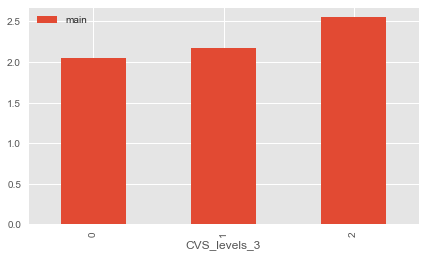

In [38]:
levels = pd.pivot_table(data, values=['main'], index=['CVS_levels_3'],aggfunc=np.mean)
levels.plot(kind='bar')
print "This plot needs to be redone with standard deviation bars and colored by level and stars given the tests above"
print '0-1 => -'
print '1-2 => *'
print '0-2 => ***'

### Post-hoc analysis on experience in physic undergraduate labs

This plot needs to be redone with standard deviation bars and organized by sim, colored by level


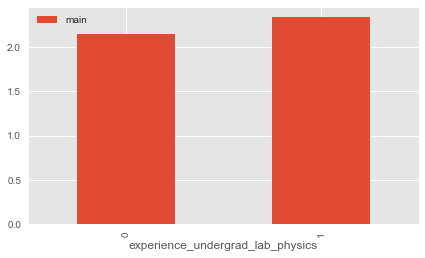

In [39]:
posthoc_exp_physics_labs = pd.pivot_table(data, values=['main'], index=['experience_undergrad_lab_physics'],aggfunc=(np.mean))
posthoc_exp_physics_labs.plot(kind='bar')
print "This plot needs to be redone with standard deviation bars and organized by sim, colored by level"

### Post-hoc analysis on order

This plot needs to be redone with standard deviation bars and organized by sim, colored by level


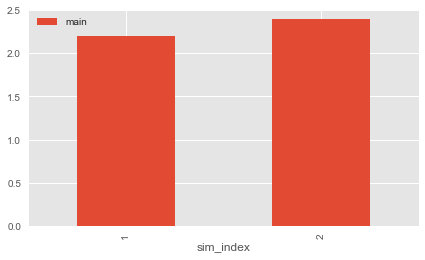

In [40]:
posthoc_sim_index = pd.pivot_table(data, values=['main'], index=['sim_index'],aggfunc=(np.mean))
posthoc_sim_index.plot(kind='bar')
print "This plot needs to be redone with standard deviation bars and organized by sim, colored by level"

### Post-hoc analysis on variable

This plot needs to be redone with standard deviation bars and organized by sim, colored by level


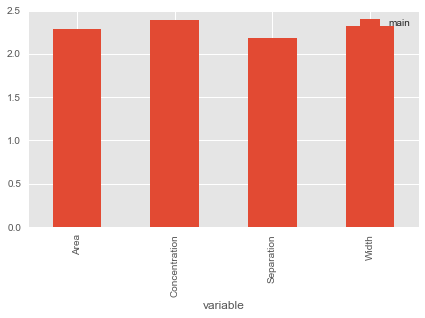

In [41]:
posthoc_variable = pd.pivot_table(data, values=['main'], index=['variable'],aggfunc=(np.mean))
posthoc_variable.plot(kind='bar')
print "This plot needs to be redone with standard deviation bars and organized by sim, colored by level"

## Let's investigate how CVS relationship with knowledge changes depending on the variable

### Overall - with viz

In [42]:
data.head()

,sid,variable,pre,main,sim,CVS_table_2,CVS_graph_2,CVS_table_3,CVS_graph_3,CVS_table_4,...,sim_index,level_experience_sims,experience_undergrad_lab_physics,used_similar_sim_L,used_similar_sim_C,used_similar_sim,CVS_levels_2,CVS_levels_3,CVS_levels_4,CVS_levels_5
0,10127163,Concentration,1.0,3.0,L,1,1,1,1,1,...,1,1,1,0.0,0.0,0.0,2,2,2,2
1,10232160,Concentration,1.0,1.0,L,1,1,1,1,1,...,1,1,1,1.0,0.0,1.0,2,2,2,0
2,10537160,Concentration,1.0,2.0,L,1,0,1,0,0,...,2,1,0,1.0,0.0,1.0,1,1,0,0
3,10375163,Concentration,0.0,2.0,L,1,0,1,0,1,...,2,2,1,0.0,0.0,0.0,1,1,1,1
4,10420167,Concentration,1.0,3.0,L,1,1,1,1,1,...,2,3,1,0.0,0.0,0.0,2,2,2,2


In [43]:
per_variable = pd.pivot_table(data, values=['main'], index=['variable','CVS_levels_3'],aggfunc=(np.mean))
per_variable

main
variable      CVS_levels_3       
Area          0             2.016
              1             2.263
              2             2.554
Concentration 0             2.096
              1             2.227
              2             2.649
Separation    0             2.130
              1             1.867
              2             2.328
Width         0             1.967
              1             2.227
              2             2.667

This plot needs to be redone with standard deviation bars and organized by sim, colored by level


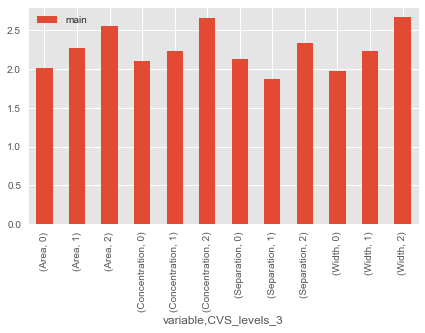

In [44]:
per_variable.plot(kind='bar')
print "This plot needs to be redone with standard deviation bars and organized by sim, colored by level"

### Width

In [45]:
variable = 'Width'
formula = 'main ~ C(CVS_levels_3) + pre + C(sim_index) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim'
model = ols(formula, data[data['variable']==variable]).fit()
print "Model: ",formula
aov_table = anova_lm(model, typ=3)
eta_squared(aov_table)
omega_squared(aov_table)
print "\nAnova table using type 3 errors\n"
print(aov_table)
print "\nHere is the linear model with coefficients and confidence intervals:\n"
print clean_summary(model)

Model:  main ~ C(CVS_levels_3) + pre + C(sim_index) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim

Anova table using type 3 errors

                                  sum_sq     df        F     PR(>F)     eta_sq  omega_sq
Intercept                         63.269    1.0  136.023  2.195e-22  4.444e-01     0.440
C(CVS_levels_3)                   11.431    2.0   12.288  1.211e-05  8.029e-02     0.074
C(sim_index)                       0.731    1.0    1.572  2.120e-01  5.135e-03     0.002
pre                                0.294    1.0    0.633  4.277e-01  2.067e-03    -0.001
level_experience_sims              0.053    1.0    0.115  7.351e-01  3.755e-04    -0.003
experience_undergrad_lab_physics   0.216    1.0    0.465  4.962e-01  1.521e-03    -0.002
used_similar_sim                   1.267    1.0    2.724  1.011e-01  8.900e-03     0.006
Residual                          65.119  140.0      NaN        NaN        NaN       NaN

Here is the linear model with coef

### Concentration

In [46]:
variable = 'Concentration'
formula = 'main ~ C(CVS_levels_3) + pre + C(sim_index) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim'
model = ols(formula, data[data['variable']==variable]).fit()
print "Model: ",formula
aov_table = anova_lm(model, typ=3)
eta_squared(aov_table)
omega_squared(aov_table)
print "\nAnova table using type 3 errors\n"
print(aov_table)
print "\nHere is the linear model with coefficients and confidence intervals:\n"
print clean_summary(model)

Model:  main ~ C(CVS_levels_3) + pre + C(sim_index) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim

Anova table using type 3 errors

                                  sum_sq     df        F     PR(>F)  eta_sq   omega_sq
Intercept                         50.730    1.0  155.534  1.783e-24   0.456  4.517e-01
C(CVS_levels_3)                   10.137    2.0   15.540  8.035e-07   0.091  8.500e-02
C(sim_index)                       1.787    1.0    5.480  2.065e-02   0.016  1.309e-02
pre                                1.413    1.0    4.333  3.919e-02   0.013  9.743e-03
level_experience_sims              0.375    1.0    1.150  2.853e-01   0.003  4.395e-04
experience_undergrad_lab_physics   0.491    1.0    1.505  2.219e-01   0.004  1.477e-03
used_similar_sim                   0.665    1.0    2.038  1.557e-01   0.006  3.034e-03
Residual                          45.664  140.0      NaN        NaN     NaN        NaN

Here is the linear model with coefficients and confi

### Area

In [47]:
variable = 'Area'
formula = 'main ~ C(CVS_levels_3) + pre + C(sim_index) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim'
model = ols(formula, data[data['variable']==variable]).fit()
print "Model: ",formula
aov_table = anova_lm(model, typ=3)
eta_squared(aov_table)
omega_squared(aov_table)
print "\nAnova table using type 3 errors\n"
print(aov_table)
print "\nHere is the linear model with coefficients and confidence intervals:\n"
print clean_summary(model)

Model:  main ~ C(CVS_levels_3) + pre + C(sim_index) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim

Anova table using type 3 errors

                                  sum_sq     df       F     PR(>F)     eta_sq  omega_sq
Intercept                         38.905    1.0  91.240  5.889e-17  3.572e-01     0.352
C(CVS_levels_3)                    5.753    2.0   6.746  1.596e-03  5.281e-02     0.045
C(sim_index)                       0.038    1.0   0.090  7.647e-01  3.521e-04    -0.004
pre                                3.764    1.0   8.827  3.495e-03  3.455e-02     0.031
level_experience_sims              0.238    1.0   0.559  4.559e-01  2.189e-03    -0.002
experience_undergrad_lab_physics   0.239    1.0   0.561  4.552e-01  2.195e-03    -0.002
used_similar_sim                   0.295    1.0   0.692  4.070e-01  2.708e-03    -0.001
Residual                          59.696  140.0     NaN        NaN        NaN       NaN

Here is the linear model with coefficients 

### Separation

In [48]:
variable = 'Separation'
formula = 'main ~ C(CVS_levels_3) + pre + C(sim_index) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim'
model = ols(formula, data[data['variable']==variable]).fit()
print "Model: ",formula
aov_table = anova_lm(model, typ=3)
eta_squared(aov_table)
omega_squared(aov_table)
print "\nAnova table using type 3 errors\n"
print(aov_table)
print "\nHere is the linear model with coefficients and confidence intervals:\n"
print clean_summary(model)

Model:  main ~ C(CVS_levels_3) + pre + C(sim_index) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim

Anova table using type 3 errors

                                  sum_sq     df       F     PR(>F)     eta_sq   omega_sq
Intercept                         32.564    1.0  76.502  6.240e-15  3.263e-01  3.206e-01
C(CVS_levels_3)                    1.804    2.0   2.119  1.240e-01  1.808e-02  9.506e-03
C(sim_index)                       1.353    1.0   3.179  7.674e-02  1.356e-02  9.256e-03
pre                                3.491    1.0   8.202  4.828e-03  3.498e-02  3.059e-02
level_experience_sims              0.432    1.0   1.016  3.153e-01  4.331e-03  6.585e-05
experience_undergrad_lab_physics   0.495    1.0   1.163  2.827e-01  4.959e-03  6.916e-04
used_similar_sim                   0.073    1.0   0.172  6.786e-01  7.351e-04 -3.515e-03
Residual                          59.593  140.0     NaN        NaN        NaN        NaN

Here is the linear model with coef

Findings:
* CVS_levels=2 (graph) matters for all except Separation
* Pre matters for all except Width

# What affects use CVS-like inquiry strategies?

For some reason adding students in the matric turns it into a singular matrix and fails the analysis. Probably because two students are exactly identical?

## Overall, how much to they use it?

In [49]:
data['CVS_table'] = data['CVS_table_3']
data['CVS_graph'] = data['CVS_graph_3']
sums = pd.pivot_table(data, values=['CVS_table','CVS_graph'], index=['sid'], aggfunc=np.sum)

In [50]:
once = len(sums[sums['CVS_table']>0])/float(N)*100
all4 = len(sums[sums['CVS_table']==4])/float(N)*100
print "{0}% of students use CVS table once and {1}% do it for all variables.".format(int(once),int(all4))
once = len(sums[sums['CVS_graph']>0])/float(N)*100
all4 = len(sums[sums['CVS_graph']==4])/float(N)*100
print "{0}% of students use CVS graph once and {1}% do it for all variables.".format(int(once),int(all4))

81% of students use CVS table once and 35% do it for all variables.
65% of students use CVS graph once and 26% do it for all variables.


## Are they consistent in their usage of CVS graph?

In [51]:
sums2 = pd.pivot_table(data, values=['CVS_graph'], index=['sid','sim'], aggfunc=np.sum)
sums2 = sums2.reset_index(level=['sim','sid'])
# sums2.head()

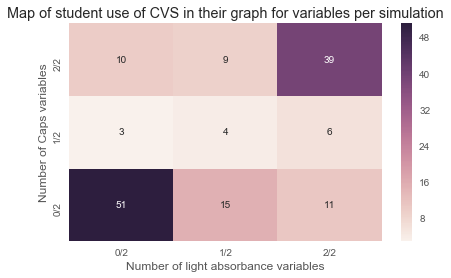

In [52]:
cvs_sim = np.zeros((3,3),dtype=int)
for i in range(3):
    for j in range(3):
        cvs_sim[i,j] = len(set(sums2[(sums2['sim']=='C')&(sums2['CVS_graph']==i)]['sid'])&set(sums2[(sums2['sim']=='L')&(sums2['CVS_graph']==j)]['sid']))
ax = sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d")
ax.set_xticklabels(['0/2','1/2','2/2'])
ax.set_yticklabels(['0/2','1/2','2/2'])
plt.xlabel('Number of light absorbance variables')
plt.ylabel('Number of Caps variables')
plt.title('Map of student use of CVS in their graph for variables per simulation')

High usage is consistent. If they do CVS with 1 variable in one sim, they do it with 2 in the other (probaly second sim).We'll see how order makes a difference later.

## How does incoming knowledge affect doing CVS

In [53]:
# export_data = data[["sid","variable","pre","main","sim","CVS_graph","sim_index"]]
# export_data.to_csv('dataframe for logreg of CVS.csv')

In [54]:
formula = 'CVS_graph ~ pre*variable + C(sim_index)*variable + pre*C(sim_index) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim'
print 'model: ', formula,'\n'
from patsy import dmatrices
Y, X = dmatrices(formula, data, return_type = 'dataframe')
# print X.columns
logit = Logit(Y, X)
model = logit.fit()
print model.summary()
# aov_table = anova_lm(model)
# eta_squared(aov_table)
# omega_squared(aov_table)
# # print "\nAnova table using type 2 errors\n"
# print(aov_table)

model:  CVS_graph ~ pre*variable + C(sim_index)*variable + pre*C(sim_index) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim 

Optimization terminated successfully.
         Current function value: 0.639344
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              CVS_graph   No. Observations:                  592
Model:                          Logit   Df Residuals:                      576
Method:                           MLE   Df Model:                           15
Date:                Sun, 28 Jan 2018   Pseudo R-squ.:                 0.07204
Time:                        00:17:18   Log-Likelihood:                -378.49
converged:                       True   LL-Null:                       -407.88
                                        LLR p-value:                 4.097e-07
                                                  coef    std err          z      P>|z|      [0.025  

### Parismonious model

In [55]:
formula = 'CVS_graph ~ pre + variable + C(sim_index) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim'
print 'model: ', formula,'\n'
from patsy import dmatrices
Y, X = dmatrices(formula, data, return_type = 'dataframe')
# print X.columns
logit = Logit(Y, X)
model = logit.fit()
print model.summary()
# aov_table = anova_lm(model)
# eta_squared(aov_table)
# omega_squared(aov_table)
# # print "\nAnova table using type 2 errors\n"
# print(aov_table)

model:  CVS_graph ~ pre + variable + C(sim_index) + C(sim) + level_experience_sims + experience_undergrad_lab_physics + used_similar_sim 

Optimization terminated successfully.
         Current function value: 0.647876
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              CVS_graph   No. Observations:                  592
Model:                          Logit   Df Residuals:                      583
Method:                           MLE   Df Model:                            8
Date:                Sun, 28 Jan 2018   Pseudo R-squ.:                 0.05966
Time:                        00:17:18   Log-Likelihood:                -383.54
converged:                       True   LL-Null:                       -407.88
                                        LLR p-value:                 7.359e-08
                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

d:\applications\anaconda2\lib\site-packages\statsmodels\base\model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
d:\applications\anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
d:\applications\anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
d:\applications\anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In order of what affects CVS_graph most:
* experience in undergraduate labs
* order
* level of experience in sims
* prior knowledge

Having used a similar sim doesn't matter, variable doesn't matter and sim doesn't matter.

### post hoc of experience in undergraduate labs

Here is prob that they do CVS graph depending on the experience_undergrad_lab_physics


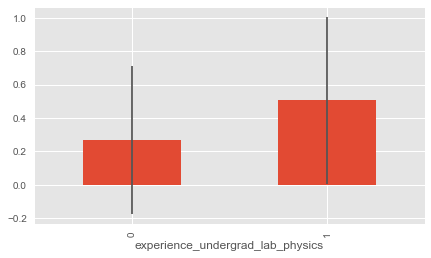

In [56]:
cvs_exp = pd.pivot_table(data, values=['CVS_graph'], index=['experience_undergrad_lab_physics'],aggfunc=(np.mean,np.std))
print "Here is prob that they do CVS graph depending on the experience_undergrad_lab_physics"
cvs_exp['CVS_graph']['mean'].plot.bar(yerr=cvs_exp['CVS_graph']['std'])

### post hoc of activity order

Here is prob that they do CVS graph depending on sim_index


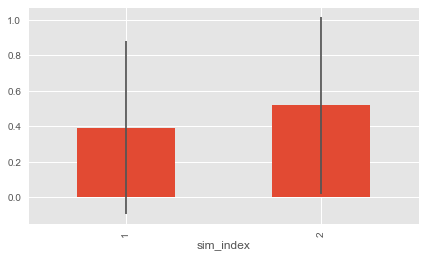

In [57]:
cvs_exp = pd.pivot_table(data, values=['CVS_graph'], index=['sim_index'],aggfunc=(np.mean,np.std))
print "Here is prob that they do CVS graph depending on sim_index"
cvs_exp['CVS_graph']['mean'].plot.bar(yerr=cvs_exp['CVS_graph']['std'])

### post hoc of experience with sims

Here is prob that they do CVS graph depending on level_experience_sims
where:
 0 -> None
 1 -> 1-2 (roughly)
 2 -> 3-5 (roughly)
 3 -> 6+ (roughly)


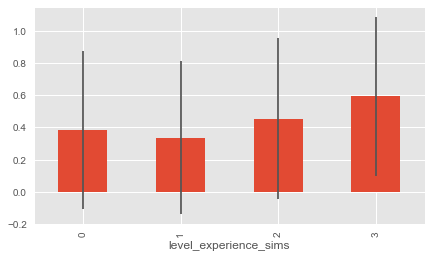

In [58]:
cvs_exp = pd.pivot_table(data, values=['CVS_graph'], index=['level_experience_sims'],aggfunc=(np.mean,np.std))
print "Here is prob that they do CVS graph depending on level_experience_sims"
cvs_exp['CVS_graph']['mean'].plot.bar(yerr=cvs_exp['CVS_graph']['std'])
print '''where:
 0 -> None
 1 -> 1-2 (roughly)
 2 -> 3-5 (roughly)
 3 -> 6+ (roughly)'''

### post hoc of pre

Here is the avg pre score of students depending if they do CVS graph or not


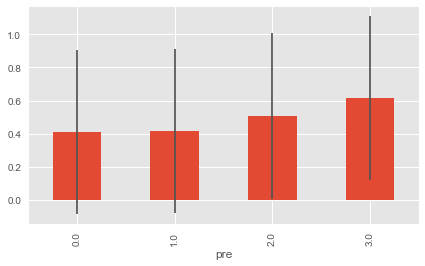

In [59]:
cvs_pre = pd.pivot_table(data, values=['CVS_graph'], index=['pre'],aggfunc=(np.mean,np.std))
print "Here is the avg pre score of students depending if they do CVS graph or not"
cvs_pre['CVS_graph']['mean'].plot.bar(yerr=cvs_pre['CVS_graph']['std'])